ENV: celiac_env3

# Pseudobulk analysis of VisiumHD data

## Imports

In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import plotly.express as px
from adjustText import adjust_text
from tqdm import tqdm
import gseapy as gp
import os
import warnings
from datetime import datetime
from scipy.stats import zscore
import scipy
from sklearn.decomposition import PCA
import math
from scipy.sparse import issparse
from statsmodels.stats.multitest import multipletests
from scipy.stats import ranksums
import scipy.stats
import dill
import session_info2

np.random.seed(1)

# import py_funcs
import plot_gsea

warnings.filterwarnings("ignore")

mpl.rcParams['pdf.fonttype'] = 42 # to edit text in Illustrator
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams.update({
    "font.size": 14,    
    "axes.titlesize": 16,    
    "axes.labelsize": 14,  
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,  
    "legend.fontsize": 14
})

# cm = 1/2.54 # centimeters in inches
LOAD_ARIAL = True
if LOAD_ARIAL:
    # set the default font to Arial
    from matplotlib.font_manager import FontProperties, fontManager
    from matplotlib import rcParams
    # Path to Arial font
    arial_path = '/mnt/x/common/joint_projects/spatial_celiac/utils/Arial.ttf'

    # Define font properties with the specific path
    arial_font = FontProperties(fname=arial_path)
    fontManager.addfont(arial_path)

    # Set the font as the default for all text elements
    rcParams['font.family'] = arial_font.get_family()
    rcParams['font.sans-serif'] = [arial_font.get_name()]

In [2]:
fast_load = True
if fast_load:
    fast_load_prefix = "/mnt/d/celiac_files/"
else:   
    fast_load_prefix = ""

In [3]:
pb_subfolder_path = os.getcwd()+"/pseudobulk_data/"
sample_annot_df = pd.read_csv(f"{pb_subfolder_path}sample_annotations.csv", index_col=0)
sample_annot_df

Diagnosis     Sex   Age  VisiumHD   Flex
P080    Celiac  Female   8.5      True  False
P109    Celiac  Female   5.0      True  False
P105    Celiac  Female   4.5      True   True
P076    Celiac  Female   5.5      True   True
P004    Celiac    Male  11.5      True   True
P072    Celiac    Male   8.5      True   True
P116    Celiac    Male  10.0     False   True
P102    Celiac    Male  10.0      True  False
P054    Celiac    Male   5.5      True   True
P052   Control  Female  15.0      True   True
P033   Control  Female  16.0      True   True
P046   Control  Female  11.0      True   True
P038   Control    Male   6.0      True   True
P123   Control    Male  11.0     False   True

## Load SINGLE CELL data to identify compartment specific genes

In [4]:
adata = sc.read_h5ad(fast_load_prefix+"10x_flex_all_samples_processed_bg.h5ad")
adata

AnnData object with n_obs × n_vars = 53270 × 18129
    obs: 'sample_name', 'batch', 'clinical_group', 'processing_method', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'log10_total_counts', 'leiden', 'cell_type_lvl1', 'cell_type_lvl2', 'epi_umap1', 'epi_umap2', 'entero_umap1', 'entero_umap2', 'stroma_umap1', 'stroma_umap2', 'epi_leiden', 'stroma_leiden', 'imm_leiden', 'stroma_umap_1', 'stroma_umap_2', 'immune_umap_1', 'immune_umap_2'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'n_cells_by_counts-

3it [00:00, 14.42it/s]


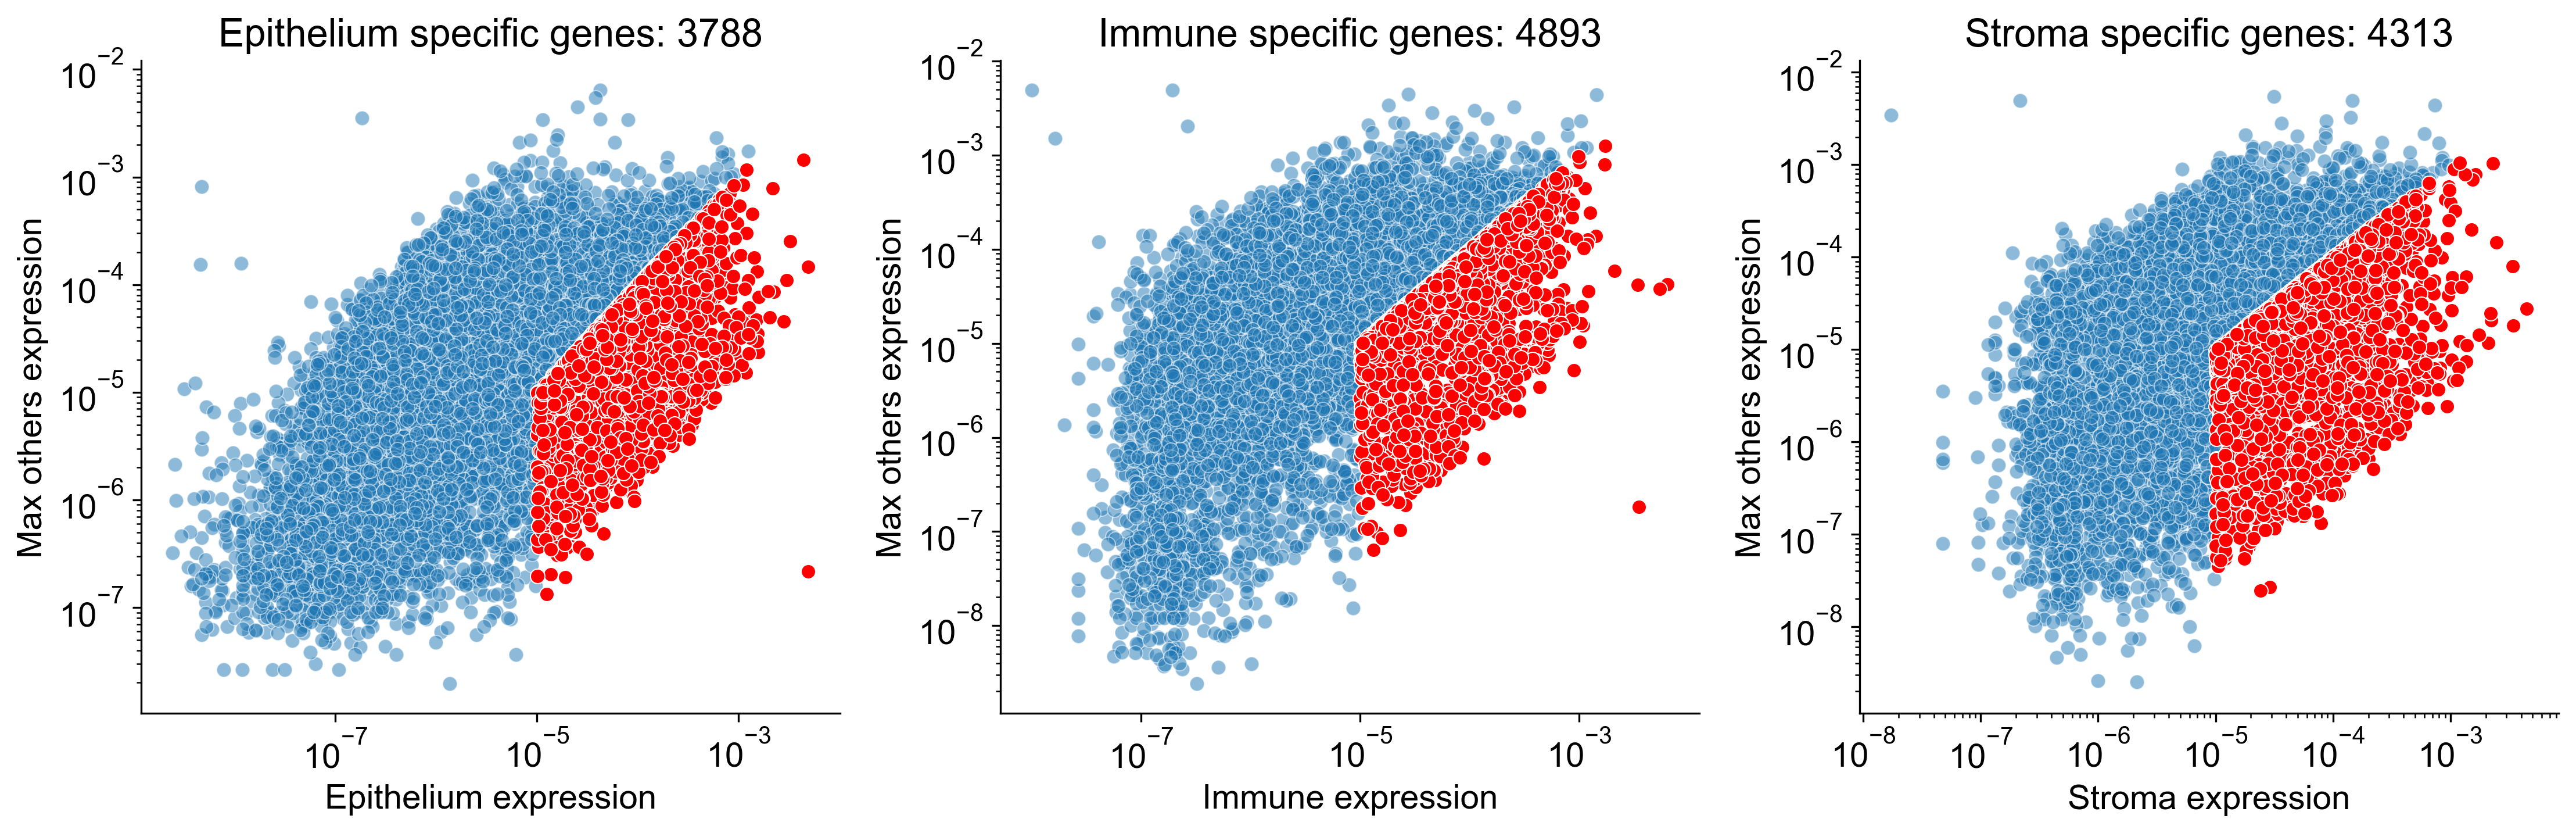

In [5]:
lvl1_types = adata.obs['cell_type_lvl1'].unique().tolist()
pb_lvl1 = pd.DataFrame(index=adata.var_names)
for my_compartment in lvl1_types:
    compartment_ad = adata[adata.obs['cell_type_lvl1'] == my_compartment].copy()
    pb_lvl1[my_compartment] = compartment_ad.layers['mat_norm'].mean(axis=0).A1

# identify compartment specific genes
FC_THRESH = 1
EXP_THRESH = 1e-5
compartment_specific_genes = {}
fig, axes = plt.subplots(1, len(lvl1_types), figsize=(5 * len(lvl1_types), 5), dpi=300)

for idx, my_compartment in tqdm(enumerate(lvl1_types)):
    my_compartment_expression = pb_lvl1.loc[:, my_compartment]
    other_compartments_max = pb_lvl1.loc[:, pb_lvl1.columns != my_compartment].max(axis=1)
    compartment_specific_genes[my_compartment] = pb_lvl1.index[
        (pb_lvl1.loc[:, my_compartment] > other_compartments_max * FC_THRESH) &
        (pb_lvl1.loc[:, my_compartment] > EXP_THRESH)
    ]

    ax = axes[idx]
    sns.scatterplot(x=my_compartment_expression, y=other_compartments_max, alpha=0.5, ax=ax)

    # scatter compartment specific genes
    sns.scatterplot(
        x=my_compartment_expression.loc[compartment_specific_genes[my_compartment]],
        y=other_compartments_max.loc[compartment_specific_genes[my_compartment]],
        color='red', ax=ax
    )

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(f"{my_compartment} expression")
    ax.set_ylabel("Max others expression")
    ax.set_title(f"{my_compartment} specific genes: {len(compartment_specific_genes[my_compartment])}")
    sns.despine()

plt.tight_layout()
plt.show()

## Load VisiumHD data

In [6]:
annotated_data_path = fast_load_prefix+"joint_ad.dill"#"all_ad_w_annotations_UMI100_leiden1.5.dill"
with open(annotated_data_path, 'rb') as f:
    all_ad = dill.load(f)

all_ad

AnnData object with n_obs × n_vars = 718521 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'cell_x_um', 'cell_y_um', 'geometry', 'sample_name', 'macrozone', 'MM_LP_crypt', 'brunner', 'villus', 'immune', 'lowest_lumen', 'crypt_base', 'pixel_class', 'bc', 'slide', 'sum_of_umis', 'block_id', 'pt', 'age', 'sex', 'group', 'ttg', 'inflammation_bulb', 'inflammation_2nd_part', 'visium_batch', 'dv200', 'uscd', 'block_name', 'notes', 'median_sum_of_umis', 'crypt_villi_part'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'
    layers: 'counts', 'mat_norm', 'log_norm'

In [7]:
fig_s1_save_path = os.getcwd()+"/figures/fig_s1/"
if not os.path.exists(fig_s1_save_path):
    os.makedirs(fig_s1_save_path)


In [8]:
samples_to_keep = ["ST_033","ST_038","ST_052","ST_046","ST_054","ST_004","ST_072",
"ST_076","ST_105","ST_102","ST_109B1","ST_080B1"]
print(all_ad.shape)
all_ad = all_ad[all_ad.obs['sample_name'].isin(samples_to_keep), :]
print(all_ad.shape)

(718521, 18085)
(517198, 18085)


In [9]:
# select only epithelial pixels
print(all_ad.shape)
all_ad = all_ad[all_ad.obs['pixel_class'] == "epithelium", :]
print(all_ad.shape)

(517198, 18085)
(241286, 18085)


In [10]:
all_ad.obs['sample_name'].unique()

array(['ST_033', 'ST_038', 'ST_052', 'ST_046', 'ST_004', 'ST_054',
       'ST_072', 'ST_105', 'ST_076', 'ST_102', 'ST_109B1', 'ST_080B1'],
      dtype=object)

In [11]:
# create pseudobulk of each sample
adata_samples = adata.obs['sample_name'].unique().tolist()
relevant_samples = all_ad.obs['sample_name'].unique().tolist()
relevant_genes = np.intersect1d(adata.var_names, all_ad.var_names)
pb_samples = pd.DataFrame(index=relevant_genes, columns=relevant_samples)


pb_approach = 'sum_then_mat_norm'#'mean_over_mat_norm'

for sample in tqdm(relevant_samples):
    tmp_ad = all_ad[all_ad.obs['sample_name'] == sample, relevant_genes].copy()
    
    # filter out brunner glands
    tmp_ad = tmp_ad[~tmp_ad.obs['brunner']]

    # filter out immune
    tmp_ad = tmp_ad[~tmp_ad.obs['immune']]

    # calculate mat_norm
    if pb_approach == 'mean_over_mat_norm':
        tmp_ad.layers['mat_norm'] = sc.pp.normalize_total(tmp_ad, target_sum=1, inplace=False, layer='counts')['X']
        pb_samples[sample] = tmp_ad.layers['mat_norm'].mean(axis=0).A1
    elif pb_approach == 'sum_then_mat_norm':
        pb_samples[sample] = pd.Series(tmp_ad[:,relevant_genes].layers['counts'].sum(axis=0).A1, index=relevant_genes).div(tmp_ad.layers['counts'].sum(axis=0).sum())

pb_samples

100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


ST_033    ST_038        ST_052        ST_046        ST_004  \
A1CF     7.398415e-05  0.000059  6.510319e-05  6.398869e-05  3.371396e-05   
A2M      6.913691e-05  0.000035  6.628153e-05  1.292529e-04  2.431296e-05   
A2ML1    1.275589e-07  0.000000  0.000000e+00  2.125870e-07  1.296691e-06   
A3GALT2  2.551178e-07  0.000001  5.891691e-07  4.251741e-07  3.241728e-07   
A4GALT   4.464561e-06  0.000001  6.775445e-06  5.739850e-06  4.214246e-06   
...               ...       ...           ...           ...           ...   
ZXDC     5.465898e-05  0.000066  6.392485e-05  5.357193e-05  6.613124e-05   
ZYG11A   2.232280e-06  0.000003  4.124184e-06  2.125870e-06  4.538419e-06   
ZYG11B   3.960703e-05  0.000039  3.888516e-05  4.358034e-05  3.598318e-05   
ZYX      8.616602e-05  0.000102  1.031046e-04  1.198991e-04  1.834818e-04   
ZZEF1    2.440201e-04  0.000298  2.235897e-04  1.843129e-04  2.415087e-04   

           ST_054        ST_072    ST_105    ST_076    ST_102  ST_109B1  \
A1CF     0.000037  3.330140e-05  0.000032  0.000026  0.000000  0.000030   
A2M      0.000041  5.176853e-05  0.000037  0.000074  0.000059  0.000047   
A2ML1    0.000002  9.082198e-07  0.000002  0.000004  0.000007  0.000013   
A3GALT2  0.000001  9.082198e-07  0.000003  0.000004  0.000007  0.000000   
A4GALT   0.000005  7.265759e-06  0.000009  0.000012  0.000015  0.000017   
...           ...           ...       ...       ...       ...       ...   
ZXDC     0.000043  5.661237e-05  0.000077  0.000056  0.000030  0.000073   
ZYG11A   0.000006  3.935619e-06  0.000009  0.000008  0.000074  0.000021   
ZYG11B   0.000035  3.057674e-05  0.000034  0.000052  0.000089  0.000021   
ZYX      0.000114  2.016248e-04  0.000106  0.000098  0.000045  0.000107   
ZZEF1    0.000235  1.783138e-04  0.000229  0.000104  0.000082  0.000098   

         ST_080B1  
A1CF     0.000050  
A2M      0.000033  
A2ML1    0.000000  
A3GALT2  0.000000  
A4GALT   0.000011  
...           ...  
ZXDC     0.000088  
ZYG11A   0.000012  
ZYG11B   0.000035  
ZYX      0.000102  
ZZEF1    0.000203  

[17696 rows x 12 columns]

In [12]:
# which samples are celiac and which are control
my_samples = pb_samples.columns
celiac_samples = []
control_samples = []
for sample in my_samples:
    if all_ad.obs.loc[all_ad.obs['sample_name'] == sample, 'group'].values[0] == 'celiac':
        celiac_samples.append(sample)
    else:
        control_samples.append(sample)

print("Celiac samples: ", celiac_samples)
print("Control samples: ", control_samples)

Celiac samples:  ['ST_004', 'ST_054', 'ST_072', 'ST_105', 'ST_076', 'ST_102', 'ST_109B1', 'ST_080B1']
Control samples:  ['ST_033', 'ST_038', 'ST_052', 'ST_046']


In [13]:
lvl1_genes = {"epithelium":adata.var_names,#compartment_specific_genes['Epithelium'], 
            "non_epithelium":np.setdiff1d(adata.var_names,compartment_specific_genes['Epithelium'])}

In [14]:
# Create pseudobulk data for VISIUMHD samples, then perform DGE on internally-normalized compartment genes
MIN_EXPR = 1e-5          # expression floor for keeping a gene (max(mean_case, mean_ctrl) >= MIN_EXPR)
FDR_Q = 0.25             # BH-FDR threshold
MIN_ABS_LOG2FC = 1.0     # effect-size threshold
PSEUDOCOUNT = 1e-6       # for log fold-change stability

dge_tbls = {}

all_samples = celiac_samples + control_samples
ced_cols = pd.Index(celiac_samples)
ctrl_cols = pd.Index(control_samples)

# Slice pb_samples columns once (big win)
pb_all = pb_samples.loc[:, all_samples]

for compartment, genes in lvl1_genes.items():
    compartment_genes = np.intersect1d(genes, pb_samples.index)
    n_genes = len(compartment_genes)
    print(f"Number of genes in compartment {compartment}: {n_genes}")
    if n_genes == 0:
        dge_tbls[compartment] = pd.DataFrame()
        continue

    # Subset to genes x samples for this compartment
    expr = pb_all.loc[compartment_genes].copy()

    # Column-wise sum normalization (safe for zero-sum columns)
    libsize = expr.sum(axis=0)
    libsize = libsize.mask(libsize == 0, np.nan)
    expr = expr.div(libsize, axis=1).fillna(0.0)

    # Precompute group matrices
    ced_mat = expr[ced_cols].to_numpy()
    ctrl_mat = expr[ctrl_cols].to_numpy()

    # Means per gene
    ced_mean = ced_mat.mean(axis=1)
    ctrl_mean = ctrl_mat.mean(axis=1)
    max_mean = np.maximum(ced_mean, ctrl_mean)

    # Filter low-expression genes early (saves a lot of work)
    keep = max_mean >= MIN_EXPR
    if not np.any(keep):
        dge_tbls[compartment] = pd.DataFrame(index=compartment_genes)
        continue

    kept_genes = compartment_genes[keep]
    ced_mat_k = ced_mat[keep, :]
    ctrl_mat_k = ctrl_mat[keep, :]
    ced_mean_k = ced_mean[keep]
    ctrl_mean_k = ctrl_mean[keep]
    max_mean_k = max_mean[keep]

    # log2FC + helper column
    log2fc = np.log2((ced_mean_k + PSEUDOCOUNT) / (ctrl_mean_k + PSEUDOCOUNT))
    log10_max = np.log10(PSEUDOCOUNT + max_mean_k)

    # Wilcoxon rank-sum test per gene (loop is fine; ranksums isn't vectorized)
    pvals = np.empty(len(kept_genes), dtype=float)
    for i in tqdm(range(len(kept_genes))):
        _, pvals[i] = ranksums(ced_mat_k[i, :], ctrl_mat_k[i, :])

    # BH-FDR
    pvals_adj = multipletests(pvals, method="fdr_bh")[1]
    significant = (pvals_adj < FDR_Q) & (np.abs(log2fc) >= MIN_ABS_LOG2FC)

    # Build result table (no per-gene .loc writes)
    rslt_df = pd.DataFrame(
        {
            "names": kept_genes,
            "celiac_mean": ced_mean_k,
            "control_mean": ctrl_mean_k,
            "log10_max": log10_max,
            "log2FC": log2fc,
            "pval": pvals,
            "pval_adj": pvals_adj,
            "significant": significant,
            "nlogq": -np.log10(pvals_adj),
        },
        index=kept_genes,
    )

    dge_tbls[compartment] = rslt_df


Number of genes in compartment epithelium: 17696


100%|██████████| 13179/13179 [00:07<00:00, 1725.94it/s]


Number of genes in compartment non_epithelium: 13990


100%|██████████| 11833/11833 [00:05<00:00, 2101.07it/s]


In [15]:
dge_tbls['epithelium'].to_csv(f"{pb_subfolder_path}dge_vhd_pseudobulk_epithelium_celiac_vs_control.csv", index=True)
dge_tbls['non_epithelium'].to_csv(f"{pb_subfolder_path}dge_vhd_pseudobulk_non_epithelium_celiac_vs_control.csv", index=True)

In [16]:
rslt_df.head()

names  celiac_mean  control_mean  log10_max    log2FC      pval  \
A2M          A2M     0.000094  1.987289e-04  -3.699559 -1.064689  0.061726   
A4GALT    A4GALT     0.000021  1.214236e-05  -4.664604  0.719938  0.089429   
AAAS        AAAS     0.000188  2.043489e-04  -3.687508 -0.123126  0.865135   
AADACL2  AADACL2     0.000031  5.925432e-06  -4.491449  2.219394  0.027248   
AADACL3  AADACL3     0.000012  6.951223e-07  -4.885497  2.940910  0.033752   

         pval_adj  significant     nlogq  
A2M      0.128774         True  0.890172  
A4GALT   0.164065        False  0.784985  
AAAS     0.884189        False  0.053455  
AADACL2  0.083402         True  1.078825  
AADACL3  0.099968         True  1.000138

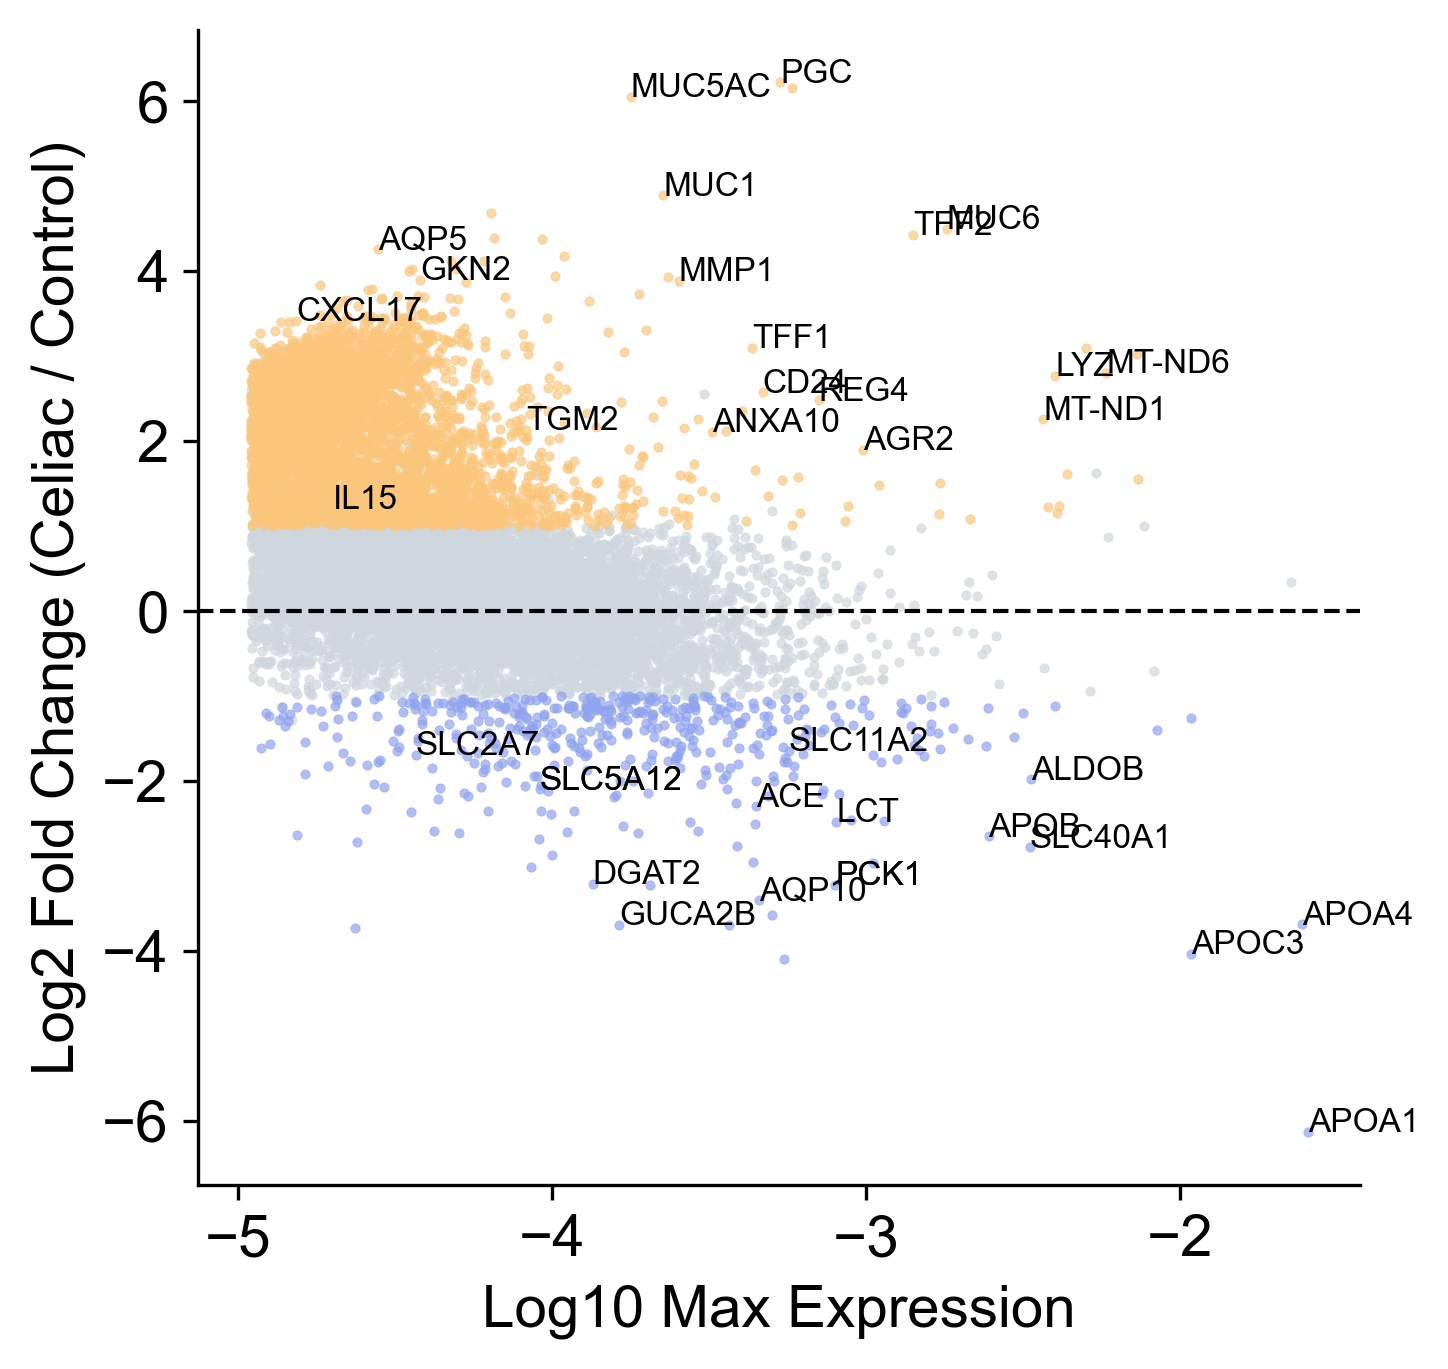

In [17]:
diagnosis_palette = {"Control": "#8fa3ee", "Celiac": "#fac67c", "control": "#8fa3ee", "celiac": "#fac67c"}
epi_dge = dge_tbls['epithelium'].copy()
epi_dge.index.set_names('names', inplace=True)

fig,ax = plt.subplots(figsize=(5,5), dpi=300)
dot_size = 5
# plot non significant genes
sns.scatterplot(data=epi_dge[epi_dge['significant'] == False], 
                x='log10_max', y='log2FC', edgecolor=None, alpha=0.7, s=dot_size, color='#cfd6de')
# plot significant genes on celiac with celiac color
sns.scatterplot(data=epi_dge[(epi_dge['significant'] == True) & (epi_dge['log2FC'] > 0)], 
                x='log10_max', y='log2FC', edgecolor=None, alpha=0.7, s=dot_size, color=diagnosis_palette['celiac'])

# plot significant genes on control with control color
sns.scatterplot(data=epi_dge[(epi_dge['significant'] == True) & (epi_dge['log2FC'] < 0)], 
                x='log10_max', y='log2FC', edgecolor=None, alpha=0.7, s=dot_size, color=diagnosis_palette['control'])

plt.ylabel('Log2 Fold Change (Celiac / Control)')
plt.xlabel('Log10 Max Expression')

# add some gene label
genes_to_label = ['LCT',"MUC5AC","TFF1","REG4","CD24","GKN2","APOA1","PCK1","AQP10","SLC5A12","APOA4","AGR2","ANXA10",
                  "TGM2","DGAT2","SLC2A7","PCK1","MUC6","PGC","LYZ","TFF2","AQP5","MUC1","MMP1","CXCL17","APOC3",
                  "GUCA2B","MT-ND6","MT-ND1","ALDOB","SLC40A1","APOB","SLC5A12","SLC11A2","ACE","IL15"]

# make sure that the genes are significant
genes_to_label = [gene for gene in genes_to_label if gene in epi_dge[epi_dge['significant']]['names'].values]

texts = []
for gene in genes_to_label:
    gene_data = dge_tbls['epithelium'][dge_tbls['epithelium']['names'] == gene]
    if not gene_data.empty:
        x = gene_data['log10_max'].values[0]
        y = gene_data['log2FC'].values[0]
        texts.append(plt.text(x, y, gene, fontsize=8, weight='bold'))
# adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))

# add line at y=0
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.legend().remove()
sns.despine()

# rasterize
for coll in ax.collections:
    coll.set_rasterized(True)

plt.show()

fig.savefig(fig_s1_save_path+"/fig_s1_A_epi_bulk_MA.pdf")

In [18]:
epi_markers = pd.read_csv("enterocyte_zonation_markers.csv", index_col=False)
epi_markers

# find the FC of each of the markers
markers_data = []  # Use a list to collect rows
# make epi_markers into a dictionary of lists
markers_dict = {}  # iterate along columns
for col in epi_markers.columns:
    markers_dict[col] = epi_markers[col].dropna().tolist()
for zone, genes in markers_dict.items():
    for gene in genes:
        if gene in epi_dge.index:
            log2fc = epi_dge.loc[gene, 'log2FC']
            markers_data.append({'gene': gene, 'zone': zone, 'log2FC': log2fc})

# Create the DataFrame from the collected data
markers_df = pd.DataFrame(markers_data)
markers_df

gene            zone    log2FC
0   EXOC3L4  bottom_markers  0.055378
1     AKAP7  bottom_markers -0.542513
2    EPS8L3  bottom_markers -0.386129
3       KHK  bottom_markers -0.680223
4     AADAC  bottom_markers -0.323355
..      ...             ...       ...
89    APOA1     tip_markers -6.137281
90    APOA4     tip_markers -3.692642
91  SLC46A1     tip_markers -2.968377
92    PTPRR     tip_markers -1.269492
93    AQP10     tip_markers -3.408773

[94 rows x 3 columns]

Kruskal-Wallis test p-value: 3.5551098812566533e-06
tip vs mid: p-value = 0.002971684016717225
tip vs bottom: p-value = 1.651209476835411e-06
mid vs tip: p-value = 0.002971684016717225
mid vs bottom: p-value = 0.37974539366049775
bottom vs tip: p-value = 1.651209476835411e-06
bottom vs mid: p-value = 0.37974539366049775


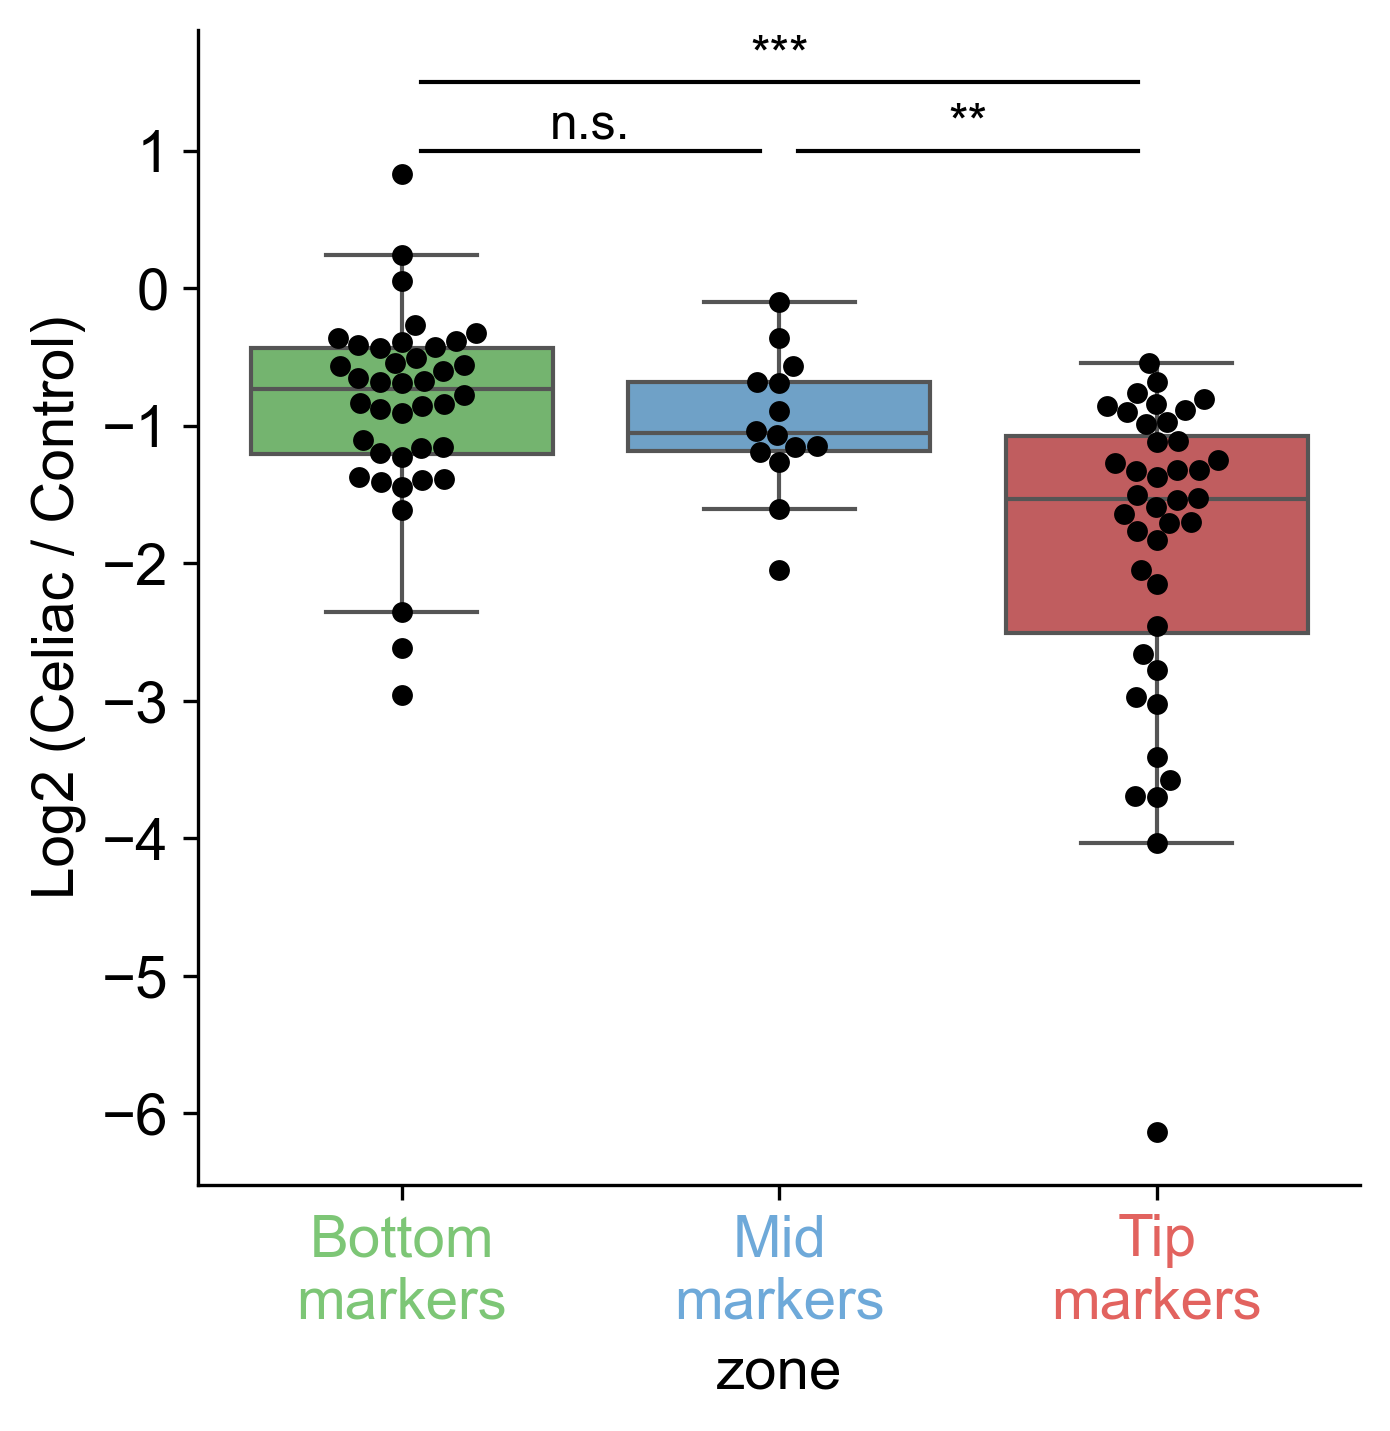

In [19]:
# plot using seaborn boxplot
fig,ax = plt.subplots(figsize=(5,5), dpi=300)
sns.boxplot(data=markers_df, x='zone', y='log2FC', palette=["#6abf64","#60a3d6","#d04c4f"], showfliers=False)
plt.ylabel('Log2 (Celiac / Control)')
plt.xlabel("")
# add swarmplot
sns.swarmplot(data=markers_df, x='zone', y='log2FC', color='black', size=5)
# set x labels to be rotated and aligned right 
# plt.xticks(rotation=45, ha='right')
# change xticklabels to Capitalize and drop underscores
new_labels = ["Bottom\nmarkers", "Mid\nmarkers", "Tip\nmarkers"]
plt.gca().set_xticklabels(new_labels)

# add kruskal wallis test
fc_dict = {}
fc_dict['tip'] = markers_df[markers_df['zone'] == 'tip_markers']['log2FC']
fc_dict['mid'] = markers_df[markers_df['zone'] == 'mid_markers']['log2FC']
fc_dict['bottom'] = markers_df[markers_df['zone'] == 'bottom_markers']['log2FC']
stat, pval = scipy.stats.kruskal(
    fc_dict['tip'],
    fc_dict['mid'],
    fc_dict['bottom']
)
print(f"Kruskal-Wallis test p-value: {pval}")

# compare each pair in fc_dict using wilcoxon
pairwise_pvals = {}
for zone1 in fc_dict:
    for zone2 in fc_dict:
        if zone1 != zone2:
            stat, pval = scipy.stats.ranksums(fc_dict[zone1], fc_dict[zone2])
            pairwise_pvals[f"{zone1} vs {zone2}"] = pval

# Print pairwise comparisons
for comparison, pval in pairwise_pvals.items():
    print(f"{comparison}: p-value = {pval}")

# add significant lines and astriks
y_1 = 1
delta = 0.05
h=0.01

# ax.plot([1+delta, 2-delta], [y_1, y_1], lw=1, c='k')
astricks_dict = {0.05: "*", 0.01: "**", 0.001: "***"}

comp_tuples = [(0,1,1,'bottom vs mid'),(1,2,1,'mid vs tip'),(0,2,1.5,'bottom vs tip')]
for x1,x2,y1,dict_val in comp_tuples:
    ax.plot([x1+delta, x2-delta], [y1, y1], lw=1, c='k')

    flag=False
    for p_thresh in sorted(astricks_dict.keys(), reverse=False):
        if pairwise_pvals[dict_val] < p_thresh:
            ax.text((x1+x2)*.5, y1+h, astricks_dict[p_thresh], ha='center', va='bottom', color='k', fontsize=12)
            flag = True
            break
    if not flag:
        ax.text((x1+x2)*.5, y_1+h, "n.s.", ha='center', va='bottom', color='k', fontsize=12)

text_colors_dict = {"Bottom\nmarkers":"#7dc676","Mid\nmarkers":"#6ea9d9","Tip\nmarkers":"#e2635f"}
for tick_label in plt.gca().get_xticklabels():
    label_text = tick_label.get_text()
    if label_text in text_colors_dict:
        tick_label.set_color(text_colors_dict[label_text])
        # add "!" to the end of the label
        tick_label.set_text(label_text + "!")

        
        

sns.despine()
plt.show()

fig.savefig(os.getcwd()+"/figures/supp_tip_base_correlation/FigS2E_epithelium_zone_markers_fc_boxplot.pdf", bbox_inches='tight', dpi=300)

2026-01-13 15:51:02,935 [WARNING] Duplicated values found in preranked stats: 2.15% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


2026-01-13 15:51:02,937 [INFO] Parsing data files for GSEA.............................
2026-01-13 15:51:02,960 [INFO] Enrichr library gene sets already downloaded in: /home/talbarka/.cache/gseapy, use local file
2026-01-13 15:51:02,982 [INFO] 0004 gene_sets have been filtered out when max_size=1000 and min_size=5
2026-01-13 15:51:02,984 [INFO] 0316 gene_sets used for further statistical testing.....
2026-01-13 15:51:02,985 [INFO] Start to run GSEA...Might take a while..................
2026-01-13 15:51:10,446 [INFO] Congratulations. GSEApy runs successfully................



Q-value thresh: 0.25


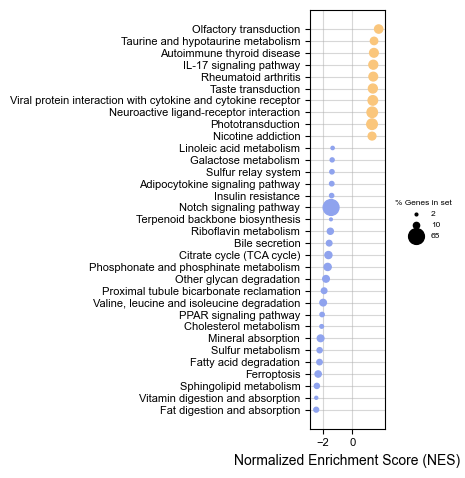

In [20]:
epi_dge['scores'] = epi_dge['log2FC'] * epi_dge['nlogq']
epi_dge = epi_dge.sort_values(by='scores', ascending=False)
epi_dge[['names','log2FC','pval_adj','significant']].head

selected_gene_set = "KEGG_2021_Human" # "MSigDB_Hallmark_2020"
pre_res = gp.prerank(rnk = epi_dge.loc[:,'scores'],
                    gene_sets=selected_gene_set,threads=4, min_size=5,max_size=1000,
                    permutation_num=1000, outdir=None, seed=6,verbose=True)

GSEA_Q_THRESH = 0.25
import importlib
importlib.reload(plot_gsea)
if pre_res.res2d['FDR q-val'].min() < GSEA_Q_THRESH:
    [_,fig] = plot_gsea.plot_GSEA(pre_res.res2d, qval_thresh=GSEA_Q_THRESH, return_figure=True, legend_round=0,pos_color=diagnosis_palette['celiac'], neg_color=diagnosis_palette['control'])
    fig.savefig(fig_s1_save_path+"/Fig_S1_C_bulk_epi_GSEA.pdf", bbox_inches='tight',)

else:
    print("No significant gene sets")


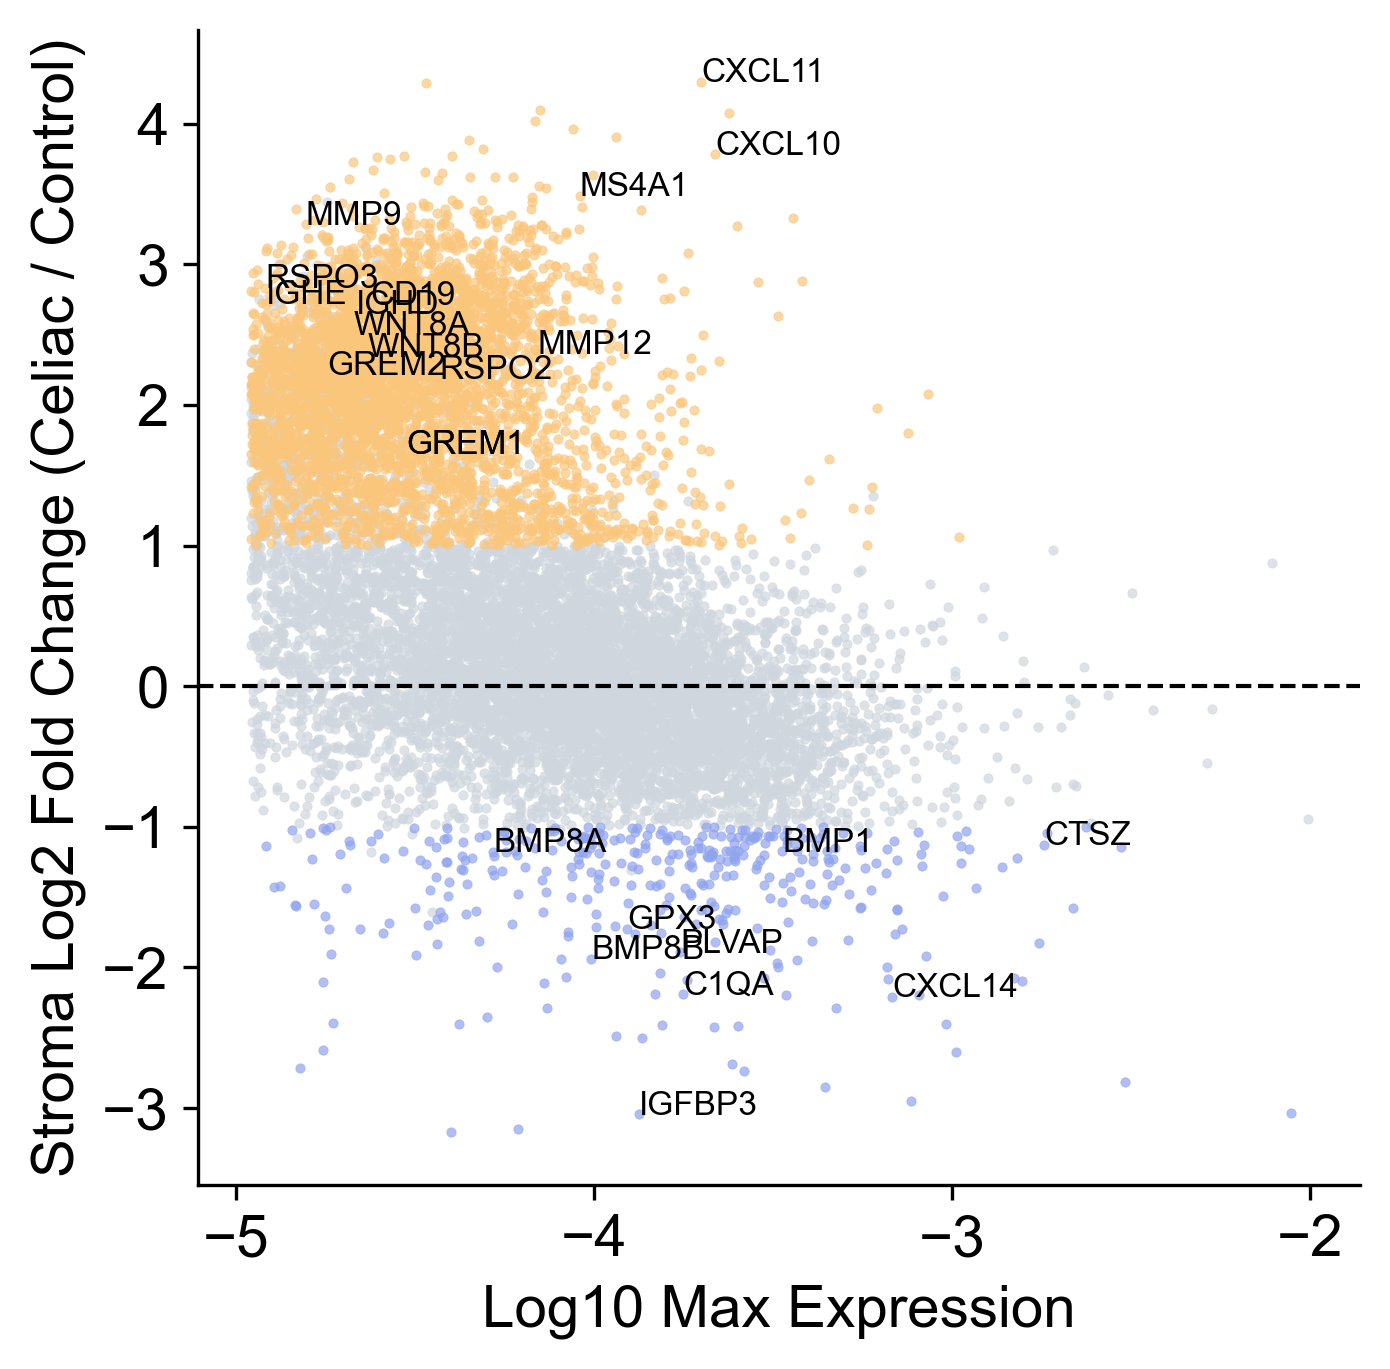

In [21]:
non_epi_dge = dge_tbls['non_epithelium'].copy()
non_epi_dge.index.set_names('names', inplace=True)


dot_size = 5
fig,ax = plt.subplots(figsize=(5,5), dpi=300)
# plot non significant genes
sns.scatterplot(data=non_epi_dge[non_epi_dge['significant'] == False], 
                x='log10_max', y='log2FC', edgecolor=None, alpha=0.7, s=dot_size, color='#cfd6de')
# plot significant genes on celiac with celiac color
sns.scatterplot(data=non_epi_dge[(non_epi_dge['significant'] == True) & (non_epi_dge['log2FC'] > 0)], 
                x='log10_max', y='log2FC', edgecolor=None, alpha=0.7, s=dot_size, color=diagnosis_palette['celiac'])

# plot significant genes on control with control color
sns.scatterplot(data=non_epi_dge[(non_epi_dge['significant'] == True) & (non_epi_dge['log2FC'] < 0)], 
                x='log10_max', y='log2FC', edgecolor=None, alpha=0.7, s=dot_size, color=diagnosis_palette['control'])


# add some gene label
genes_to_label = ['MMP12',"MMP9","GREM1","IGFBP3","MS4A1","CD19","BMP8B","BMP8A",
"C1QA", "CTSZ","CXCL14","BMP1","PLVAP","CXCL11","GPX3",
"IGHD","IGHE","RSPO3","RSPO2","CXCL10",
'GREM1', 'GREM2',"WNT8A","WNT8B"]
texts = []
for gene in genes_to_label:
    gene_data = dge_tbls['non_epithelium'][dge_tbls['non_epithelium']['names'] == gene]
    if not gene_data.empty:
        x = gene_data['log10_max'].values[0]
        y = gene_data['log2FC'].values[0]
        texts.append(plt.text(x, y, gene, fontsize=8, weight='bold'))
# adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))

plt.ylabel('Stroma Log2 Fold Change (Celiac / Control)')
plt.xlabel('Log10 Max Expression')

plt.axhline(0, color='black', linestyle='--', linewidth=1)

# rasterize
for coll in ax.collections:
    coll.set_rasterized(True)

# hide legend
plt.legend().remove()
sns.despine()
fig.savefig(fig_s1_save_path+"/Fig_s1_B_NON_epi_bulk_MA.pdf")
plt.show()

In [22]:
# px.scatter(non_epi_dge, x='log10_max', y='log2FC', color='significant',hover_name=non_epi_dge.index)

2026-01-13 15:51:14,910 [WARNING] Duplicated values found in preranked stats: 2.15% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2026-01-13 15:51:14,912 [INFO] Parsing data files for GSEA.............................
2026-01-13 15:51:14,933 [INFO] Enrichr library gene sets already downloaded in: /home/talbarka/.cache/gseapy, use local file
2026-01-13 15:51:14,956 [INFO] 0009 gene_sets have been filtered out when max_size=1000 and min_size=5
2026-01-13 15:51:14,958 [INFO] 0311 gene_sets used for further statistical testing.....
2026-01-13 15:51:14,958 [INFO] Start to run GSEA...Might take a while..................
2026-01-13 15:51:21,586 [INFO] Congratulations. GSEApy runs successfully................



Q-value thresh: 0.25


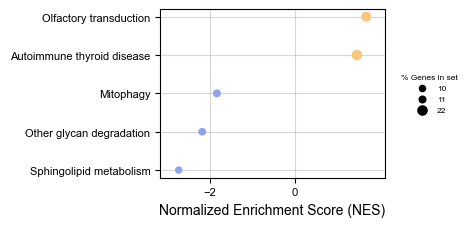

In [23]:
non_epi_dge['scores'] = non_epi_dge['log2FC'] * non_epi_dge['nlogq']
non_epi_dge = non_epi_dge.sort_values(by='scores', ascending=False)
non_epi_dge[['names','log2FC','pval_adj','significant']].head

selected_gene_set = "KEGG_2021_Human" # "MSigDB_Hallmark_2020"
pre_res = gp.prerank(rnk = non_epi_dge.loc[:,'scores'],
                    gene_sets=selected_gene_set,threads=4, min_size=5,max_size=1000,
                    permutation_num=1000, outdir=None, seed=6,verbose=True)

GSEA_Q_THRESH = 0.25
import importlib
importlib.reload(plot_gsea)
if pre_res.res2d['FDR q-val'].min() < GSEA_Q_THRESH:
    [_,fig] = plot_gsea.plot_GSEA(pre_res.res2d, qval_thresh=GSEA_Q_THRESH, return_figure=True, legend_round=0,
    pos_color=diagnosis_palette['celiac'], neg_color=diagnosis_palette['control'], fig_size=(5,2.5))
    fig.savefig(fig_s1_save_path+"/Fig_S1_D_bulk_NON_epi_GSEA.pdf", bbox_inches='tight',)
else:
    print("No significant gene sets")

In [24]:
print(datetime.now())

2026-01-13 15:51:22.478874


In [25]:
print(session_info2.session_info(dependencies=True))

pandas	2.3.1
numpy	2.2.6
anndata	0.12.0
scanpy	1.11.3
seaborn	0.13.2
matplotlib	3.10.3
plotly	6.2.0
adjustText	1.3.0
tqdm	4.67.1
gseapy	1.1.9
scipy	1.15.3
scikit-learn	1.7.1
statsmodels	0.14.5
dill	0.4.0
----	----
parso	0.8.4
PyYAML	6.0.2
numba	0.61.2
setuptools	78.1.1
six	1.17.0
sphinxcontrib-htmlhelp	2.1.0
jupyter_client	8.6.3
xarray	2025.9.0
toolz	1.0.0
platformdirs	4.3.8
wrapt	1.17.2
session-info2	0.1.2
asciitree	0.3.3
certifi	2025.7.14 (2025.07.14)
sphinxcontrib-qthelp	2.0.0
prompt_toolkit	3.0.51
idna	3.10
shapely	2.1.1
asttokens	3.0.0
charset-normalizer	3.4.2
jupyter_core	5.8.1
texttable	1.7.0
Jinja2	3.1.6
zarr	2.18.7
ipykernel	6.29.5
pure_eval	0.2.3
patsy	1.0.1
Deprecated	1.2.18
narwhals	1.47.1
sphinxcontrib-applehelp	2.0.0
traitlets	5.14.3
fonttools	4.59.0
h5py	3.14.0
geopandas	1.1.1
urllib3	2.5.0
debugpy	1.8.15
psutil	7.0.0
sphinxcontrib-devhelp	2.0.0
pillow	11.3.0
importlib_metadata	8.7.0
typing_extensions	4.14.1
python-dateutil	2.9.0.post0
jedi	0.19.2
pyproj	3.7.1
pyarrow	21